In [1]:
import pandas as pd
import numpy as np
from lifelines import CoxPHFitter

import matplotlib.pyplot as plt
%matplotlib inline

### Survival Analysis with Cox Model - AF Risk Prediction 

In [2]:
pred_file = "predicted_af_fdset_30Mar.csv"
pred_id_col = "exam_ids"
pred_class_col = "predicted_class"
prob_class3 = "prob_class3_norm"

exams_info_file = "traces100pc_threeClasses_time.csv"
exam_id_col = "id_exam"
class_col = "exam_class"

In [3]:
# Read predicted csv file
pred_df = pd.read_csv(pred_file, index_col=pred_id_col)
pred_index = pred_df.index
pred_df.head(10)

,exam_ids.1,predicted_class,prob_class1,prob_class2,prob_class3,prob_class1_norm,prob_class3_norm
exam_ids,,,,,,,
21284,21284,1.0,0.998970,0.000035,0.000994,0.999006,0.000994
924386,924386,1.0,0.995386,0.000073,0.004541,0.995459,0.004541
2939231,2939231,1.0,0.990075,0.001023,0.008902,0.991089,0.008911
761745,761745,1.0,0.999566,0.000023,0.000411,0.999589,0.000411
713438,713438,1.0,0.999525,0.000031,0.000444,0.999556,0.000444
3181141,3181141,1.0,0.974425,0.010703,0.014872,0.984967,0.015033
2735976,2735976,1.0,0.996727,0.000202,0.003070,0.996929,0.003071
2975924,2975924,2.0,0.050890,0.906287,0.042822,0.543045,0.456955
298440,298440,1.0,0.999336,0.000084,0.000580,0.999420,0.000580


In [4]:
# Read exams info file
exams_df = pd.read_csv(exams_info_file, index_col = exam_id_col)
exams_df.head(10)

,Unnamed: 0,id_patient,age,sex,AF,exam_class,split,time
id_exam,,,,,,,,
29855,9,1303179,63,F,0,1,train,37
21284,10,149539,68,F,0,1,test,148
749729,16,445398,42,M,0,1,train,4
371322,17,68340,59,M,0,1,train,20
1384433,18,10854,48,F,0,1,valid,45
3200399,19,110344,38,F,0,1,train,224
603726,26,1464955,60,M,0,1,train,141
3187610,28,1024979,30,F,0,1,train,256
805692,32,56645,33,M,0,1,train,61


In [5]:
# Keep exams that are in the predicted file
exams_df = exams_df.reindex(pred_index, fill_value=False, copy=True) # Keep ids that are in pred_csv file
print(exams_df.isnull().sum() ==0) # It should print True, all ids in pred_file should be in exams_info_file
print("Number of samples in both files are equal now: ", len(pred_df) == len(exams_df))

Unnamed: 0    True
id_patient    True
age           True
sex           True
AF            True
exam_class    True
split         True
time          True
dtype: bool
Number of samples in both files are equal now:  True


In [6]:
exams_df[class_col].value_counts()

1    191665
3      3691
2      3053
Name: exam_class, dtype: int64

In [7]:
classes1n3_mask = exams_df[class_col] != 2
sum(~classes1n3_mask)

3053

In [8]:
# Removing rows corresponding to true class equal 2
pred_df = pred_df[classes1n3_mask]
exams_df = exams_df[classes1n3_mask]
print("Number of samples in both files are still equal: ", len(pred_df) == len(exams_df))
exams_df[class_col].value_counts()

Number of samples in both files are still equal:  True


1    191665
3      3691
Name: exam_class, dtype: int64

In [9]:
# Add columns/features to exams_df
exams_df['is_male'] = exams_df['sex'] == 'M'
exams_df['AF_event'] = exams_df[class_col] == 3
print(sum(exams_df['AF_event']))
exams_df.head(10)

3691


,Unnamed: 0,id_patient,age,sex,AF,exam_class,split,time,is_male,AF_event
exam_ids,,,,,,,,,,
21284,10,149539,68,F,0,1,test,148,False,False
924386,34,1043714,69,F,0,1,test,39,False,False
2939231,40,50085,72,F,0,1,test,121,False,False
761745,41,11939,59,F,0,1,test,53,False,False
713438,43,1245882,47,M,0,1,test,128,True,False
3181141,44,146129,64,F,0,1,test,191,False,False
2735976,55,75670,47,M,0,1,test,201,True,False
298440,57,676934,64,M,0,1,test,55,True,False
910859,85,760657,53,F,0,1,test,67,False,False


### Initial model

In [10]:
# Make a survival analysis dataset
df1 = exams_df.loc[:, ['age', 'is_male', 'AF_event', 'time']].rename(columns={"time": "weeks"})
#df1 = exams_df.loc[:, ['AF_event', 'time']].rename(columns={"time": "weeks"})
sa_df = pred_df.loc[:, [prob_class3]].rename(columns={prob_class3: "class3_prob"})
sa_df = pd.concat([sa_df, df1], axis=1)

In [11]:
sa_df.head(10)

,class3_prob,age,is_male,AF_event,weeks
exam_ids,,,,,
21284,0.000994,68,False,False,148
924386,0.004541,69,False,False,39
2939231,0.008911,72,False,False,121
761745,0.000411,59,False,False,53
713438,0.000444,47,True,False,128
3181141,0.015033,64,False,False,191
2735976,0.003071,47,True,False,201
298440,0.000580,64,True,False,55
910859,0.000533,53,False,False,67


In [12]:
sa_df.isnull().sum()

class3_prob    0
age            0
is_male        0
AF_event       0
weeks          0
dtype: int64

In [13]:
# pair-wise correlation between columns
print(sa_df.corr())

             class3_prob       age   is_male  AF_event     weeks
class3_prob     1.000000  0.211210  0.074212  0.338597 -0.061567
age             0.211210  1.000000  0.062696  0.116279 -0.020541
is_male         0.074212  0.062696  1.000000  0.036258 -0.027156
AF_event        0.338597  0.116279  0.036258  1.000000 -0.015152
weeks          -0.061567 -0.020541 -0.027156 -0.015152  1.000000


In [14]:
cph = CoxPHFitter(penalizer=0.0)
cph.fit(sa_df, duration_col='weeks', event_col='AF_event', step_size=0.20)

<lifelines.CoxPHFitter: fitted with 195356 total observations, 191665 right-censored observations>

In [15]:
cph.print_summary()
'''
The hazard ratio of class3_prob is too high;
There is difficulties getting survival curves for propability groups;
The h
'''

<lifelines.CoxPHFitter: fitted with 195356 total observations, 191665 right-censored observations>
             duration col = 'weeks'
                event col = 'AF_event'
      baseline estimation = breslow
   number of observations = 195356
number of events observed = 3691
   partial log-likelihood = -38240.24
         time fit was run = 2022-05-11 08:42:36 UTC

---
              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                           
class3_prob   6.26     525.07       0.07             6.12             6.40               456.85               603.48
age           0.06       1.06       0.00             0.05             0.06                 1.06                 1.06
is_male       0.29       1.34       0.03             0.23             0.36                 1.25                 1.43

                z      p   -log2(p)
covariate                          
class3_prob 88.21 <0.005        inf
age         43.20 <0.005        inf
is_male      8.75 <0.005      58.70
---
Concordance = 0.84
Partial AIC = 76486.47
log-likelihood ratio test = 6804.32 on 3 df
-log2(p) of ll-ratio test = inf

'\nThe hazard ratio of class3_prob is too high;\nThere is difficulties getting survival curves for propability groups;\nThe h\n'

In [ ]:
# Checking the proportional hazards assumption
cph.check_assumptions( sa_df, p_value_threshold=0.05, show_plots=False)

<AxesSubplot:xlabel='log(HR) (95% CI)'>

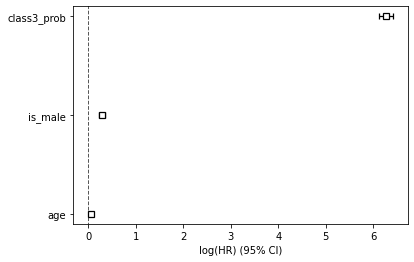

In [16]:
# plotting the coefficients
cph.plot()

In [17]:
# Generate the survival curves

min_prob = min(sa_df["class3_prob"])
max_prob = max(sa_df["class3_prob"])
print(f"\n\tMinimum probability: {min_prob: 7.5f} \n\tMaximum probability: {max_prob: 7.5f}")


	Minimum probability:  0.00000 
	Maximum probability:  0.92636


In [18]:
array = np.linspace(min_prob, max_prob, num=6)
array

array([2.53877257e-07, 1.85271253e-01, 3.70542252e-01, 5.55813252e-01,
       7.41084251e-01, 9.26355250e-01])

<AxesSubplot:>

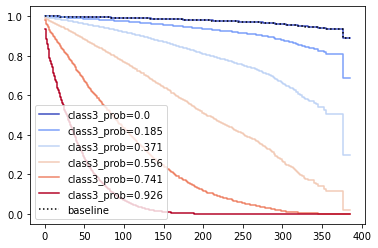

In [19]:
cph.plot_partial_effects_on_outcome(covariates='class3_prob', values = array.round(decimals=3), cmap='coolwarm')

In [20]:
# Generate the survival curves for probability ranges

first_range_mask = (sa_df["class3_prob"] > 0) & (sa_df["class3_prob"] <= 0.2)
second_range_mask = (sa_df["class3_prob"] > 0.2) & (sa_df["class3_prob"] <= 0.4)
third_range_mask = (sa_df["class3_prob"] > 0.4) & (sa_df["class3_prob"] <= 0.6)
fourth_range_mask = (sa_df["class3_prob"] > 0.6) & (sa_df["class3_prob"] <= 0.8)
fifth_range_mask = (sa_df["class3_prob"] > 0.8) & (sa_df["class3_prob"] <= 1.0)

print(len(sa_df))
print(sum(first_range_mask) + sum(second_range_mask) + sum(third_range_mask) + 
        sum(fourth_range_mask) + sum(fifth_range_mask))

195356
195356


In [21]:
sa_df[second_range_mask].shape

(889, 5)

In [22]:
#cph.predict_survival_function(pd.DataFrame(sa_df.loc[first_range_mask, 'class3_prob']), times=np.arange(0,160), conditional_after=None)

In [23]:
# Get the average partial hazard for each probability gourp
P_hazard_0 = cph.predict_partial_hazard(sa_df[first_range_mask]).mean()
P_hazard_1 = cph.predict_partial_hazard(sa_df[second_range_mask]).mean()
P_hazard_2 = cph.predict_partial_hazard(sa_df[third_range_mask]).mean()
P_hazard_3 = cph.predict_partial_hazard(sa_df[fourth_range_mask]).mean()
P_hazard_4 = cph.predict_partial_hazard(sa_df[fifth_range_mask]).mean()
print("Partial hazards, prob. group 1 upto 5: ", P_hazard_0, P_hazard_1, P_hazard_2, P_hazard_3, P_hazard_4)

Partial hazards, prob. group 1 upto 5:  1.5360404000500851 16.881212874920333 64.35272299143679 235.47297441905195 567.7721617737434


In [24]:
# Get Hazard ratio (baseline)

cph.hazard_ratios_

covariate
class3_prob    525.072693
age              1.058058
is_male          1.338132
Name: exp(coef), dtype: float64

In [25]:
# the survival probabilities of individuals over the timeline

times = [0, 52, 104, 156, 208, 260, 312, 364, 416]
cph.predict_survival_function(sa_df, times=times, conditional_after=None) 

,21284,924386,2939231,761745,713438,3181141,2735976,298440,910859,733670,...,2776560,240994,1377462,1066632,1571386,2504911,335206,925978,291572,1187945
0.0,0.999607,0.999575,0.999482,0.999764,0.999840,0.999657,0.999837,0.999581,0.999832,0.999608,...,0.999415,0.999240,0.999668,0.999810,0.999794,0.999432,0.999805,0.999329,0.999700,0.999892
52.0,0.992555,0.991949,0.990207,0.995530,0.996958,0.993511,0.996908,0.992074,0.996809,0.992582,...,0.988939,0.985656,0.993704,0.996403,0.996088,0.989253,0.996305,0.987318,0.994310,0.997946
104.0,0.984325,0.983053,0.979408,0.990572,0.993580,0.986329,0.993474,0.983315,0.993266,0.984381,...,0.976757,0.969914,0.986734,0.992410,0.991747,0.977412,0.992203,0.973374,0.988007,0.995661
156.0,0.973587,0.971457,0.965361,0.984079,0.989147,0.976948,0.988968,0.971895,0.988617,0.973682,...,0.960939,0.949561,0.977628,0.987174,0.986058,0.962032,0.986825,0.955307,0.979766,0.992660
208.0,0.960344,0.957169,0.948105,0.976031,0.983639,0.965359,0.983370,0.957822,0.982844,0.960485,...,0.941548,0.924747,0.966376,0.980675,0.979000,0.943166,0.980152,0.933218,0.969572,0.988926
260.0,0.946352,0.942092,0.929956,0.967481,0.977772,0.953094,0.977407,0.942968,0.976694,0.946542,...,0.921202,0.898875,0.954462,0.973759,0.971492,0.923361,0.973051,0.910115,0.958766,0.984939
312.0,0.920347,0.914118,0.896450,0.951453,0.966728,0.930234,0.966185,0.915398,0.965125,0.920625,...,0.883777,0.851731,0.932246,0.960762,0.957398,0.886896,0.959710,0.867814,0.938581,0.977415
364.0,0.882353,0.873362,0.848034,0.927704,0.950255,0.896685,0.949451,0.875208,0.947879,0.882755,...,0.830022,0.785059,0.899611,0.941426,0.936459,0.834443,0.939872,0.807519,0.908845,0.966140
416.0,0.802127,0.787785,0.747984,0.876170,0.914035,0.825221,0.912674,0.790719,0.910014,0.802771,...,0.720223,0.652918,0.829970,0.899127,0.890788,0.726995,0.896515,0.686183,0.845036,0.941123


<AxesSubplot:>

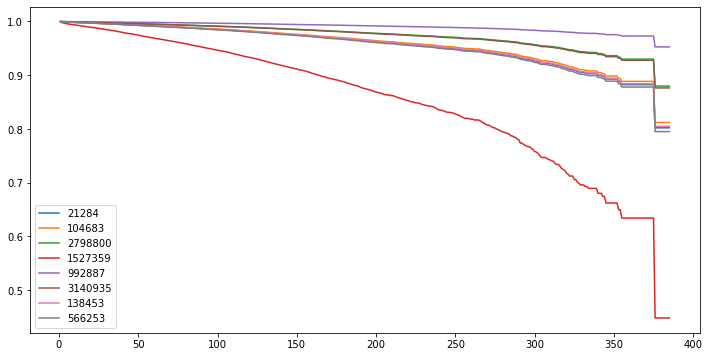

In [26]:
cph.predict_survival_function(sa_df.loc[::25000]).plot(figsize=(12,6))

In [27]:
cph.predict_survival_function(sa_df.loc[::25000])

,21284,104683,2798800,1527359,992887,3140935,138453,566253
1.0,0.999607,0.999629,0.999771,0.998571,0.999913,0.999765,0.999613,0.999591
2.0,0.999317,0.999355,0.999603,0.997518,0.999850,0.999591,0.999328,0.999290
3.0,0.999144,0.999191,0.999502,0.996890,0.999811,0.999487,0.999158,0.999110
4.0,0.998979,0.999035,0.999406,0.996290,0.999775,0.999388,0.998995,0.998938
5.0,0.998795,0.998862,0.999299,0.995624,0.999735,0.999278,0.998814,0.998747
...,...,...,...,...,...,...,...,...
378.0,0.802127,0.812012,0.879694,0.448465,0.952622,0.876294,0.804983,0.795082
380.0,0.802127,0.812012,0.879694,0.448465,0.952622,0.876294,0.804983,0.795082
381.0,0.802127,0.812012,0.879694,0.448465,0.952622,0.876294,0.804983,0.795082
383.0,0.802127,0.812012,0.879694,0.448465,0.952622,0.876294,0.804983,0.795082


In [28]:
print(sa_df.loc[::25000])

          class3_prob  age  is_male  AF_event  weeks
exam_ids                                            
21284        0.000994   68    False     False    148
104683       0.000880   67    False     False    193
2798800      0.003046   53     True     False    157
1527359      0.099014   80    False     False     12
992887       0.002626   41    False     False     57
3140935      0.000240   59    False     False    203
138453       0.051008   57     True     False    188
566253       0.007257   68    False     False     41


### Kaplan Meier

In [16]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

#### considering 4 probability groupes

In [18]:
km_df2 = sa_df.copy()
# Make columns of bins for probabilities and ages
bins = pd.IntervalIndex.from_tuples([(0, 0.1), (0.1, 0.4), (0.4, 0.7), (0.7, 1)])
#bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
km_df2['prob3_bins'] = pd.cut(km_df2['class3_prob'], bins, precision=5).cat.codes
#sa_df2['age_strata'] = pd.cut(sa_df2['age'], np.arange(15, 106, 10)).cat.codes
km_df2['age_bins'] = pd.cut(km_df2['age'], np.arange(15, 106, 10)).cat.codes
km_df2.head()

,class3_prob,age,is_male,AF_event,weeks,prob3_bins,age_bins
exam_ids,,,,,,,
21284,0.000994,68,False,False,148,0,5
924386,0.004541,69,False,False,39,0,5
2939231,0.008911,72,False,False,121,0,5
761745,0.000411,59,False,False,53,0,4
713438,0.000444,47,True,False,128,0,3


inf
248.0
82.0
40.0


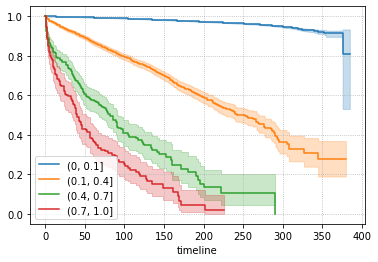

In [19]:
# Survival curves considering 4 probability groupes
kmf2 = KaplanMeierFitter()
ax2 = plt.subplot(111)
label_list2 = ['(0, 0.1]', '(0.1, 0.4]','(0.4, 0.7]', '(0.7, 1.0]']
for i in range(4):
    kmf2.fit(km_df2[km_df2['prob3_bins']==i]['weeks'], km_df2[km_df2['prob3_bins']==i]['AF_event'], label= label_list2[i])
    print(kmf2.median_survival_time_)
    kmf2.plot_survival_function(ax=ax2)
    ax2.grid(linestyle=':')
#ax2.set_xlabel("timeline (weeks)")
#ax2.set_ylabel("survival probability")
    

inf
248.0
82.0
40.0


Text(0, 0.5, 'survival probability')

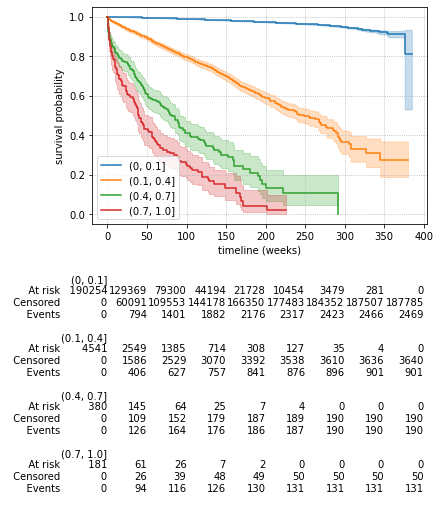

In [44]:
# Survival curves considering 4 probability groupes plus risk counts
kmf3 = {}
fig = plt.figure()
ax3 = plt.subplot(111)
label_list3 = ['(0, 0.1]', '(0.1, 0.4]','(0.4, 0.7]', '(0.7, 1.0]']
for i in range(4):
    kmf3[i] = KaplanMeierFitter()
    kmf3[i].fit(km_df2[km_df2['prob3_bins']==i]['weeks'], km_df2[km_df2['prob3_bins']==i]['AF_event'], label= label_list3[i])
    print(kmf3[i].median_survival_time_)
    ax3 = kmf3[i].plot_survival_function(ax=ax3)
   
    #plt.tight_layout()

from lifelines.plotting import add_at_risk_counts
add_at_risk_counts(kmf3[0], kmf3[1], kmf3[2], kmf3[3], ax=ax3, fig=fig)
#plt.tight_layout()
ax3.grid(linestyle=':')
ax3.set_xlabel("timeline (weeks)")
ax3.set_ylabel("survival probability")
#plt.tight_layout()    
    
#kmf.plot_survival_function(at_risk_counts=True)
#plt.tight_layout()
#plt.savefig('KM_Survival_curves.pdf')
#fig.savefig('KM_Survival_curves.pdf')
#plt.show()

### Improved model: 

#### Using Dummy Coding for predicted probabilities

In [27]:
dc_df = sa_df.copy()
dc_df.head(5)

,class3_prob,age,is_male,AF_event,weeks
exam_ids,,,,,
21284,0.000994,68,False,False,148
924386,0.004541,69,False,False,39
2939231,0.008911,72,False,False,121
761745,0.000411,59,False,False,53
713438,0.000444,47,True,False,128


In [28]:
# Make columns of bins for probabilities and ages
bins = pd.IntervalIndex.from_tuples([(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)])
dc_df['prob3_bins'] = pd.cut(dc_df['class3_prob'], bins, precision=5)
dc_df['age_bins'] = pd.cut(dc_df['age'], np.arange(15, 106, 10)).cat.codes
#dummies_prob3 = pd.get_dummies(dc_df["prob3_bins"], prefix = 'quantile')
dummies_prob3 = pd.get_dummies(dc_df["prob3_bins"])
#dc_df.head()

In [29]:
dummies_prob3.head(5)

,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
exam_ids,,,,,
21284,1,0,0,0,0
924386,1,0,0,0,0
2939231,1,0,0,0,0
761745,1,0,0,0,0
713438,1,0,0,0,0


In [30]:
dummies_prob3.sum()

(0.0, 0.2]    193906
(0.2, 0.4]       889
(0.4, 0.6]       272
(0.6, 0.8]       207
(0.8, 1.0]        82
dtype: int64

In [31]:
dc_df = pd.concat([dc_df, dummies_prob3], axis = 1)
dc_df = dc_df.drop(['class3_prob', 'age', 'prob3_bins'], axis = 1)
dc_df.head()

,is_male,AF_event,weeks,age_bins,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
exam_ids,,,,,,,,,
21284,False,False,148,5,1,0,0,0,0
924386,False,False,39,5,1,0,0,0,0
2939231,False,False,121,5,1,0,0,0,0
761745,False,False,53,4,1,0,0,0,0
713438,True,False,128,3,1,0,0,0,0


In [32]:
# Training the model with dummy coded covarietes

cph_dc = CoxPHFitter(penalizer=0.1)
cph_dc.fit(dc_df, duration_col='weeks', event_col='AF_event', step_size=0.20)

<lifelines.CoxPHFitter: fitted with 195356 total observations, 191665 right-censored observations>

In [33]:
cph_dc.print_summary()

<lifelines.CoxPHFitter: fitted with 195356 total observations, 191665 right-censored observations>
             duration col = 'weeks'
                event col = 'AF_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 195356
number of events observed = 3691
   partial log-likelihood = -40161.51
         time fit was run = 2022-05-11 08:46:44 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
is_male      0.08       1.08       0.01             0.05             0.10                 1.05                 1.11
age_bins     0.08       1.08       0.00             0.07             0.08                 1.07                 1.09
(0.0, 0.2]  -1.56       0.21       0.06            -1.69            -1.44                 0.18                 0.24
(0.2, 0.4]   1.22       3.37       0.07             1.07             1.36                 2.91                 3.90
(0.4, 0.6]   1.78       5.92       0.11             1.56             2.00                 4.76                 7.37
(0.6, 0.8]   2.29       9.83       0.11             2.07             2.50                 7.95                12.15
(0.8, 1.0]   2.65      14.17       0.15             2.35             2.95                10.51                19.09

                z      p   -log2(p)
covariate                          
is_male      5.58 <0.005      25.34
age_bins    18.48 <0.005     250.82
(0.0, 0.2] -24.36 <0.005     433.03
(0.2, 0.4]  16.29 <0.005     195.75
(0.4, 0.6]  15.96 <0.005     188.18
(0.6, 0.8]  21.14 <0.005     327.05
(0.8, 1.0]  17.42 <0.005     223.26
---
Concordance = 0.80
Partial AIC = 80337.01
log-likelihood ratio test = 2961.79 on 7 df
-log2(p) of ll-ratio test = inf

In [40]:
# Checking the proportional hazards assumption
cph_dc.check_assumptions( dc_df, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\Users\Administrotor\anaconda3\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 195356 total observations, 191665 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic      p  -log2(p)
(0.0, 0.2] km              8.11 <0.005      7.83
           rank           15.73 <0.005     13.74
(0.2, 0.4] km              4.02   0.04      4.47
           rank            6.67   0.01      6.67
(0.4, 0.6] km              4.48   0.03      4.87
           rank           10.26 <0.005      9.52
(0.6, 0.8] km              4.30   0.04      4.72
           rank            9.46 <0.005      8.90
(0.8, 1.0] km              2.60   0.11      3.23
           rank            5.75   0.02      5.93
age_bins   km              1.26   0.26      1.94
           rank            1.77   0.18      2.44
is_male    km              1.22   0.27      1.90
           rank            1.16   0.28      1.83



1. Variable '(0.0, 0.2]' failed the non-proportional test: p-value is 0.0001.

   Advice: with so few unique values (only 2), you can include `strata=['(0.0, 0.2]', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable '(0.2, 0.4]' failed the non-proportional test: p-value is 0.0098.

   Advice: with so few unique values (only 2), you can include `strata=['(0.2, 0.4]', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable '(0.4, 0.6]' failed the non-proportional test: p-value is 0.0014.

   Advice: with so few unique values (only 2), you can include `strata=['(0.4, 0.6]', ...]` in the
call in `.fit`. See documentation in link [E] below.

4. Variable '(0.6, 0.8]' failed the non-proportional test: p-value is 0.0021.

   Advice: with so few unique values (only 2), you can include `strata=['(0.6, 0.8]', ...]` in the
call in `.fit`. See documentation in link [E] below.

5. Variable '(0.8, 1.0]' failed the non-proportional test: p-value is 

[]

In [77]:
#cph_dc.plot_partial_effects_on_outcome(covariates=[ '(0.2, 0.4]', '(0.4, 0.6]', '(0.6, 0.8]', '(0.8, 1.0]'], values=np.array([[ 1, 1, 1, 1]]), cmap='coolwarm')

<AxesSubplot:>

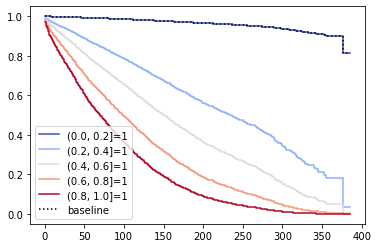

In [34]:
covariates= [dc_df.columns[4], dc_df.columns[5], dc_df.columns[6], dc_df.columns[7], dc_df.columns[8]]
#cph_dc.plot_partial_effects_on_outcome(covariates=covariates, values=np.eye(5))
cph_dc.plot_partial_effects_on_outcome(covariates=covariates, values=np.eye(5), cmap='coolwarm')

In [35]:
# Compute the hazard ratios of different probability groups, taking as reference the group (0.0.2]

h_ratios = cph_dc.hazard_ratios_
h_ratios

covariate
is_male        1.078518
age_bins       1.078822
(0.0, 0.2]     0.209685
(0.2, 0.4]     3.371036
(0.4, 0.6]     5.920987
(0.6, 0.8]     9.826773
(0.8, 1.0]    14.168601
Name: exp(coef), dtype: float64

In [36]:
m = 5 # number of probability groups
relative_h_ratios = {}
for i in range(1, m):
    relative_h_ratios[i] = h_ratios[2+i]/h_ratios[2]
    print("The hazard ratio for prob. group", i , "is:", round(relative_h_ratios[i], 3))

The hazard ratio for prob. group 1 is: 16.077
The hazard ratio for prob. group 2 is: 28.238
The hazard ratio for prob. group 3 is: 46.864
The hazard ratio for prob. group 4 is: 67.571


#### Considering only four dummy codes: (0.2, 0.4], (0.4, 0.6], (0.6, 0.8], (0.8, 1.0]

In [37]:
dc_df2 = sa_df.copy()

In [38]:
# Make columns of bins for probabilities and ages
bins = pd.IntervalIndex.from_tuples([(0, 0.2), (0.2, 0.4), (0.4, 0.6), (0.6, 0.8), (0.8, 1)])
dc_df2['prob3_bins'] = pd.cut(dc_df2['class3_prob'], bins, precision=5)
dc_df2['age_bins'] = pd.cut(dc_df2['age'], np.arange(15, 106, 10)).cat.codes
#dummies_prob3 = pd.get_dummies(dc_df["prob3_bins"], prefix = 'quantile')
four_dummies_prob3 = pd.get_dummies(dc_df2["prob3_bins"])
#dc_df.head()

In [39]:
dc_df2 = pd.concat([dc_df2, four_dummies_prob3], axis = 1)
dc_df2 = dc_df2.drop(dc_df2.columns[7], axis = 1)
dc_df2 = dc_df2.drop(['class3_prob', 'age', 'prob3_bins'], axis = 1)
dc_df2.head()

,is_male,AF_event,weeks,age_bins,"(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
exam_ids,,,,,,,,
21284,False,False,148,5,0,0,0,0
924386,False,False,39,5,0,0,0,0
2939231,False,False,121,5,0,0,0,0
761745,False,False,53,4,0,0,0,0
713438,True,False,128,3,0,0,0,0


In [40]:
# Training the model with dummy coded covarietes

cph_dc2 = CoxPHFitter(penalizer=0.1)
cph_dc2.fit(dc_df2, duration_col='weeks', event_col='AF_event', step_size=0.20)

<lifelines.CoxPHFitter: fitted with 195356 total observations, 191665 right-censored observations>

In [41]:
cph_dc2.print_summary()

<lifelines.CoxPHFitter: fitted with 195356 total observations, 191665 right-censored observations>
             duration col = 'weeks'
                event col = 'AF_event'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 195356
number of events observed = 3691
   partial log-likelihood = -40452.75
         time fit was run = 2022-05-11 08:48:26 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
is_male      0.08       1.08       0.01             0.05             0.11                 1.06                 1.11
age_bins     0.08       1.08       0.00             0.07             0.09                 1.07                 1.09
(0.2, 0.4]   2.14       8.49       0.07             2.00             2.28                 7.36                 9.80
(0.4, 0.6]   2.79      16.31       0.12             2.56             3.03                12.90                20.63
(0.6, 0.8]   3.48      32.42       0.11             3.27             3.69                26.25                40.05
(0.8, 1.0]   3.88      48.26       0.16             3.56             4.19                35.26                66.06

               z      p   -log2(p)
covariate                         
is_male     5.98 <0.005      28.73
age_bins   19.33 <0.005     274.14
(0.2, 0.4] 29.31 <0.005     624.86
(0.4, 0.6] 23.29 <0.005     396.26
(0.6, 0.8] 32.27 <0.005     756.66
(0.8, 1.0] 24.21 <0.005     427.62
---
Concordance = 0.80
Partial AIC = 80917.50
log-likelihood ratio test = 2379.30 on 6 df
-log2(p) of ll-ratio test = inf

In [31]:
# Checking the proportional hazards assumption
cph_dc2.check_assumptions( dc_df2, p_value_threshold=0.05, show_plots=False)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



C:\Users\Administrotor\anaconda3\lib\site-packages\lifelines\fitters\mixins.py:108: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  for variable in self.params_.index & (columns or self.params_.index):


<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 195356 total observations, 191665 right-censored observations>
         test_name = proportional_hazard_test

---
                 test_statistic      p  -log2(p)
(0.2, 0.4] km             34.74 <0.005     27.98
           rank           59.09 <0.005     45.92
(0.4, 0.6] km             29.94 <0.005     24.42
           rank           56.01 <0.005     43.66
(0.6, 0.8] km             25.63 <0.005     21.20
           rank           50.17 <0.005     39.37
(0.8, 1.0] km             15.08 <0.005     13.24
           rank           28.65 <0.005     23.46
age_bins   km              0.72   0.40      1.33
           rank            0.93   0.34      1.58
is_male    km              1.04   0.31      1.70
           rank            0.90   0.34      1.55



1. Variable '(0.2, 0.4]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.2, 0.4]', ...]` in the
call in `.fit`. See documentation in link [E] below.

2. Variable '(0.4, 0.6]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.4, 0.6]', ...]` in the
call in `.fit`. See documentation in link [E] below.

3. Variable '(0.6, 0.8]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.6, 0.8]', ...]` in the
call in `.fit`. See documentation in link [E] below.

4. Variable '(0.8, 1.0]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include `strata=['(0.8, 1.0]', ...]` in the
call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/

[]

<AxesSubplot:>

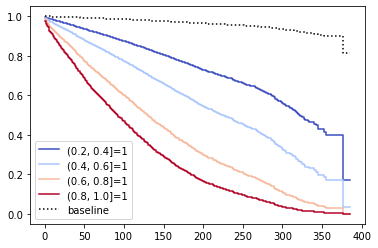

In [42]:
covariates= [dc_df2.columns[4], dc_df2.columns[5], dc_df2.columns[6], dc_df2.columns[7]]
#cph_dc.plot_partial_effects_on_outcome(covariates=covariates, values=np.eye(5))
cph_dc2.plot_partial_effects_on_outcome(covariates=covariates, values=np.eye(4), cmap='coolwarm')

<AxesSubplot:>

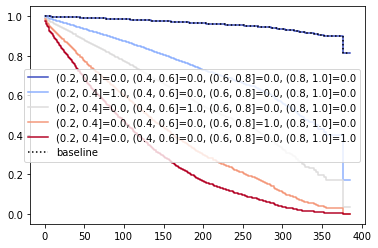

In [47]:
covariates= [dc_df2.columns[4], dc_df2.columns[5], dc_df2.columns[6], dc_df2.columns[7]]
val=np.eye(4)
val = np.append(np.array([[0,0,0,0]]),val, axis= 0)   # or np.vstack
label_list = ['(0, 0.2]', '(0.2, 0.4]','(0.4, 0.6]','(0.6, 0.8]', '(0.8, 1.0]']
cph_dc2.plot_partial_effects_on_outcome(covariates=covariates, values=val, cmap='coolwarm', label=label_list)

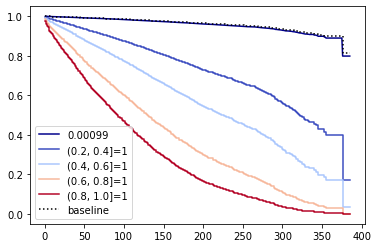

In [43]:
label_list = ['(0, 0.2]', '(0.2, 0.4]','(0.4, 0.6]','(0.6, 0.8]', '(0.8, 1.0]']
ax5 = plt.subplot(111)
a = dc_df2.iloc[0]
#a.name = '(0.0,0.2]'
a.name = str(np.round(sa_df.iloc[0]['class3_prob'], 5))
cph_dc2.predict_survival_function(a).plot(ax=ax5, color='darkblue')
cph_dc2.plot_partial_effects_on_outcome(covariates=covariates, values=np.eye(4), cmap='coolwarm', ax=ax5, label=label_list)
ax5.legend()
plt.show()

In [44]:
h_ratios2 = cph_dc2.hazard_ratios_
h_ratios2

covariate
is_male        1.084298
age_bins       1.082502
(0.2, 0.4]     8.494753
(0.4, 0.6]    16.311024
(0.6, 0.8]    32.419617
(0.8, 1.0]    48.260951
Name: exp(coef), dtype: float64

#### Modeling baseline hazard and survival with parametric models

##### Fit to a parametric baseline with cubic splines

In [58]:
cph_spline = CoxPHFitter(baseline_estimation_method="spline", n_baseline_knots=6, penalizer=0.1)
cph_spline.fit(dc_df2, duration_col='weeks', event_col='AF_event', step_size=0.20)

C:\Users\Administrotor\anaconda3\lib\site-packages\autograd\tracer.py:48: RuntimeWarning: overflow encountered in multiply
  return f_raw(*args, **kwargs)
C:\Users\Administrotor\anaconda3\lib\site-packages\autograd\numpy\numpy_vjps.py:34: RuntimeWarning: overflow encountered in multiply
  defvjp(anp.multiply,    lambda ans, x, y : unbroadcast_f(x, lambda g: y * g),


<lifelines.CoxPHFitter: fitted with 195356 total observations, 191665 right-censored observations>

In [59]:
cph_spline.print_summary(3, model="parametric model with cubic splines")

model,lifelines.CoxPHFitter
duration col,'weeks'
event col,'AF_event'
penalizer,0.1
l1 ratio,0.0
number of baseline knots,6
baseline estimation,spline
number of observations,195356
number of events observed,3691
log-likelihood,-34663.141
time fit was run,2022-05-11 09:19:39 UTC


In [47]:
# Checking the proportional hazards assumption
#cph_spline.check_assumptions(dc_df2, p_value_threshold=0.05, show_plots=False)

In [50]:
#from lifelines.statistics import proportional_hazard_test
#results = proportional_hazard_test(cph_spline, dc_df2, time_transform='rank')
#results.print_summary(decimals=3, model="untransformed variables")

<AxesSubplot:>

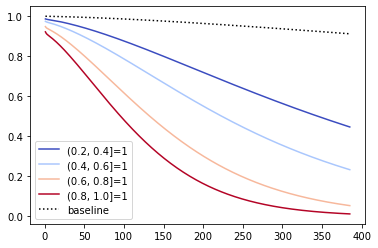

In [60]:
covariates2= [dc_df2.columns[4], dc_df2.columns[5], dc_df2.columns[6], dc_df2.columns[7]]

cph_spline.plot_partial_effects_on_outcome(covariates=covariates2, values=np.eye(4), cmap='coolwarm')

In [51]:
cph_spline.hazard_ratios_

param  covariate 
beta_  is_male        1.082936
       age_bins       1.082738
       (0.2, 0.4]     8.627711
       (0.4, 0.6]    15.570710
       (0.6, 0.8]    31.292528
       (0.8, 1.0]    47.237239
       Intercept      0.001280
phi1_  Intercept      1.140978
phi2_  Intercept      0.949408
phi3_  Intercept      0.979478
phi4_  Intercept      0.990274
phi5_  Intercept      0.994192
phi6_  Intercept      0.996330
Name: exp(coef), dtype: float64

##### Accelerated failure time model with The Weibull AFT model

In [61]:
from lifelines import WeibullAFTFitter

In [62]:
aft = WeibullAFTFitter()
aft.fit(dc_df2, duration_col='weeks', event_col='AF_event')

<lifelines.WeibullAFTFitter: fitted with 195356 total observations, 191665 right-censored observations>

In [63]:
aft.print_summary(3)

<lifelines.WeibullAFTFitter: fitted with 195356 total observations, 191665 right-censored observations>
             duration col = 'weeks'
                event col = 'AF_event'
   number of observations = 195356
number of events observed = 3691
           log-likelihood = -32390.337
         time fit was run = 2022-05-11 09:25:14 UTC

---
                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                          
lambda_ (0.2, 0.4] -2.365      0.094      0.064           -2.490           -2.239                0.083                0.107
        (0.4, 0.6] -2.959      0.052      0.092           -3.139           -2.780                0.043                0.062
        (0.6, 0.8] -3.322      0.036      0.088           -3.495           -3.149                0.030                0.043
        (0.8, 1.0] -3.830      0.022      0.122           -4.069           -3.590                0.017                0.028
        age_bins   -0.502      0.605      0.013           -0.527           -0.477                0.590                0.621
        is_male    -0.295      0.744      0.030           -0.355           -0.236                0.702                0.790
        Intercept  10.584  39484.371      0.093           10.401           10.767            32876.512            47420.344
rho_    Intercept   0.105      1.111      0.013            0.079            0.131                1.082                1.140

                         z       p   -log2(p)
param   covariate                            
lambda_ (0.2, 0.4] -36.997 <0.0005    992.913
        (0.4, 0.6] -32.301 <0.0005    757.972
        (0.6, 0.8] -37.580 <0.0005   1024.267
        (0.8, 1.0] -31.353 <0.0005    714.376
        age_bins   -38.676 <0.0005        inf
        is_male     -9.767 <0.0005     72.437
        Intercept  113.262 <0.0005        inf
rho_    Intercept    7.858 <0.0005     47.865
---
Concordance = 0.804
AIC = 64796.673
log-likelihood ratio test = 5804.929 on 6 df
-log2(p) of ll-ratio test = inf

In [64]:
print(aft.median_survival_time_)
print(aft.mean_survival_time_)
# exp(−3.83)=0.022, means approximately a 98% decrease in mean/median survival time. ???

3810.7923784749714
5097.906960027307


<AxesSubplot:xlabel='log(accelerated failure rate) (95% CI)'>

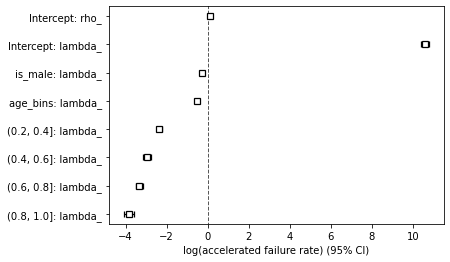

In [65]:
# Plotting the log(accelerated failure rate) for all covariates
aft.plot()

<AxesSubplot:>

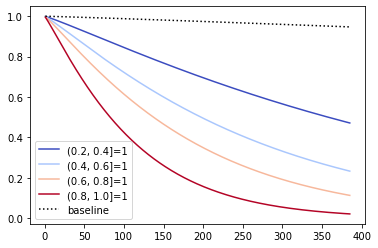

In [66]:
covariates2= [dc_df2.columns[4], dc_df2.columns[5], dc_df2.columns[6], dc_df2.columns[7]]
aft.plot_partial_effects_on_outcome(covariates=covariates2, values=np.eye(4), cmap='coolwarm')